<a href="https://colab.research.google.com/github/fikrifaizz/hr-attrition-optimizer/blob/main/notebooks/modeling_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
df = pd.read_parquet("../data/processed/hr_cleaned.parquet")
X = df.drop(columns=['attrition'])
y = df['attrition']
X_encoded = pd.get_dummies(X, drop_first=True)

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,False,False,False,False,False,True,False,False,True,True
1,49,279,8,1,3,61,2,2,2,5130,...,False,False,False,False,True,False,False,True,False,False
2,37,1373,2,2,4,92,2,1,3,2090,...,True,False,False,False,False,False,False,False,True,True
3,33,1392,3,4,4,56,3,1,3,2909,...,False,False,False,False,True,False,False,True,False,True
4,27,591,2,1,1,40,3,1,2,3468,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,3,41,4,2,4,2571,...,True,False,False,False,False,False,False,True,False,False
1466,39,613,6,1,4,42,2,3,1,9991,...,False,False,False,False,False,False,False,True,False,False
1467,27,155,4,3,2,87,4,2,2,6142,...,False,False,True,False,False,False,False,True,False,True
1468,49,1023,2,3,4,63,2,2,2,5390,...,False,False,False,False,False,True,False,True,False,False


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
param_grid = {
    'n_estimators': [100, 200],       # Jumlah pohon
    'max_depth': [10, 20, None],      # Kedalaman pohon (None = sampai habis)
    'min_samples_leaf': [1, 2, 4],    # Minimal sampel di daun (Mencegah overfitting)
    'class_weight': ['balanced', 'balanced_subsample'] # Strategi imbalance
}

In [5]:
rf_base = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,                
    scoring='recall',  
    n_jobs=-1,           
    verbose=2
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

print("\n--- HASIL TUNING ---")
print(f"Parameter Terbaik: {grid_search.best_params_}")
print(f"Recall Terbaik di Training (CV): {grid_search.best_score_:.2%}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, n_estimators=200; total time=   0.2s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   0.3s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   0.3s
[CV] END cl

In [6]:
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("\n--- FINAL REPORT (TEST SET) ---")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob):.4f}")


--- FINAL REPORT (TEST SET) ---
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       247
           1       0.42      0.23      0.30        47

    accuracy                           0.83       294
   macro avg       0.64      0.59      0.60       294
weighted avg       0.79      0.83      0.81       294

AUC-ROC Score: 0.7699


/var/folders/1d/rtg1b32x7sg4fj4dmx9191l40000gn/T/ipykernel_51449/2892193268.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pd.concat([coeffs.head(5), coeffs.tail(5)]),


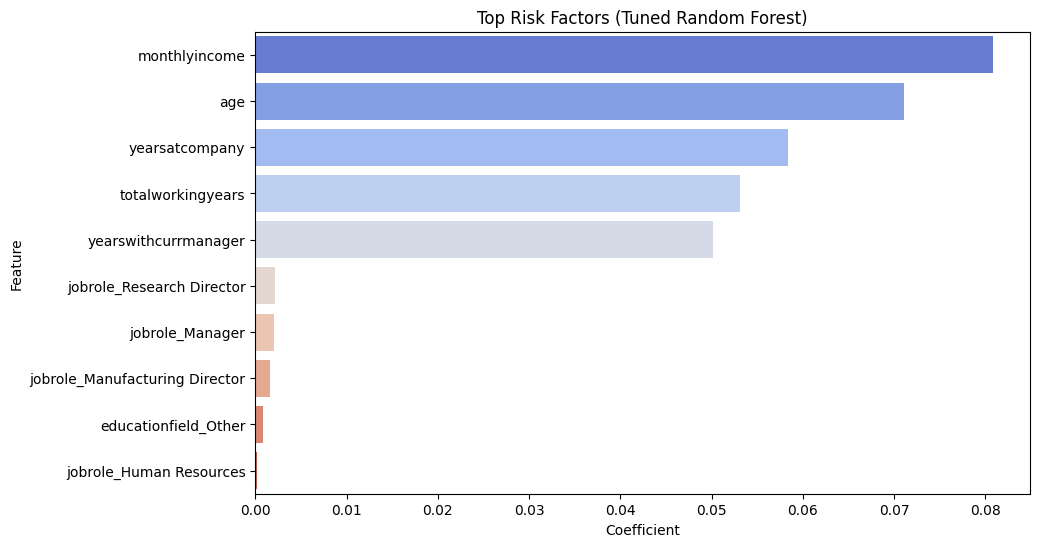

In [8]:
coeffs = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': best_rf.feature_importances_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
# Plot Top 5 Positif & Top 5 Negatif
sns.barplot(data=pd.concat([coeffs.head(5), coeffs.tail(5)]), 
            y='Feature', x='Coefficient', palette='coolwarm')
plt.title("Top Risk Factors (Tuned Random Forest)")
plt.show()